# Baseline Cluster Analysis

Compute various statistics to help interpret the baseline clustering model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [11, 6]

%matplotlib inline

In [2]:
# Read in data
data = pd.read_csv('../data/features/merged.csv')

In [3]:
# Read in beat boundaries
beats_gdf = gp.read_file('../data/geographies/Boundaries - Police Beats (current).geojson')
beats_gdf.drop(['beat', 'district', 'sector'], axis=1, inplace=True)
beats_gdf.columns = ['BEAT', 'geometry']
beats_gdf['BEAT'] = beats_gdf['BEAT'].astype(int)

## Create training data

In [4]:
# From here on out, we'll use a separate variable "training_data" for filtered data. 
# It's good not to overwrite the original 'data' variable
# in case we want to recover the filtered columns later.
training_data = data.copy()

### ... by filtering columns

In [5]:
# Drop all demographics
remove_cols = ['BLACK', 'WHITE', 'HISPANIC', 'CENSUS']
for dem in remove_cols:
    cols = [c for c in training_data.columns if dem in c]
    training_data.drop(cols, axis=1, inplace=True)
training_data.columns

Index(['BEAT', 'YEAR', 'COMPLAINTS_POLICE_SHOOTING', 'COMPLAINTS_TOTAL',
       'CRIME_TOTAL', 'CRIME_ARREST', 'CRIME_DOMESTIC', 'ISR_TOTAL_STOPS',
       'ISR_SEARCH', 'ISR_ARREST', 'UOF_TOTAL_COUNT', 'UOF_POLICE_W_WEAPON',
       'UOF_POLICE_WO_WEAPON'],
      dtype='object')

### .. by aggregating rows

For model selection, since we're eventually clustering by beat, we'll aggregate by summing all years together.


In [6]:
training_data = training_data.drop('YEAR',axis=1).groupby(by='BEAT').agg(np.sum)
beats = training_data.reset_index()['BEAT']
training_data.head(2)

,COMPLAINTS_POLICE_SHOOTING,COMPLAINTS_TOTAL,CRIME_TOTAL,CRIME_ARREST,CRIME_DOMESTIC,ISR_TOTAL_STOPS,ISR_SEARCH,ISR_ARREST,UOF_TOTAL_COUNT,UOF_POLICE_W_WEAPON,UOF_POLICE_WO_WEAPON
BEAT,,,,,,,,,,,
111,0.0,25,8926,2217,196,2501,217,193.0,102,10,34
112,0.0,9,6570,1074,89,968,82,80.0,64,4,23


## Setup Best Model & Hyperparameters

In [7]:
from sklearn.cluster import AgglomerativeClustering

# See Model Selection.ipynb for why we chose these params.
cluster_model_params = {'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 5}
cluster_model = AgglomerativeClustering()
cluster_model.set_params(**cluster_model_params)

AgglomerativeClustering(linkage='complete', n_clusters=5)

## Run the model

In [8]:
from util_clustering import get_clusters
cluster_labels, clustered_data = get_clusters(training_data, beats, cluster_model)

In [9]:
clustered_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Cluster,BEAT
0,2.154153,-0.556139,1.204775,-1.169982,2.916138,-0.345154,1,111
1,-0.712959,-0.397213,0.825376,-0.792141,2.122832,-0.394202,4,112
2,-0.662858,-0.397982,0.398048,0.343189,1.169731,-0.530594,4,113
3,-0.783367,-0.285063,0.855373,0.000778,1.045543,-0.769667,4,114
4,-2.824287,0.650939,0.038874,0.125945,0.573302,-0.183643,4,121


# Summarize Clustering

## Size of the clusters

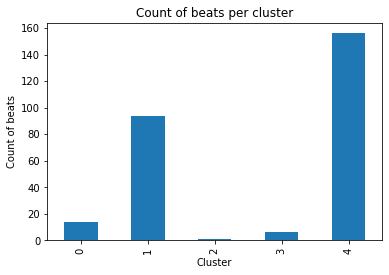

In [10]:
clustered_data['Cluster'].value_counts().sort_index().plot.bar()
plt.title('Count of beats per cluster')
plt.xlabel('Cluster')
plt.ylabel('Count of beats')
plt.savefig('../report/figures/baseline/beats_per_cluster.png', dpi=300)

## Characteristics of the clusters

In [11]:
# Merge in all data
cluster_training_data = clustered_data.merge(training_data.reset_index(), on='BEAT')

<ipython-input-12-d7135dd08491>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_training_data.groupby(['Cluster'])['CRIME_TOTAL', 'ISR_TOTAL_STOPS'].mean().plot.bar()


Text(0.5, 1.0, 'Crime and ISR Stops by Cluster')

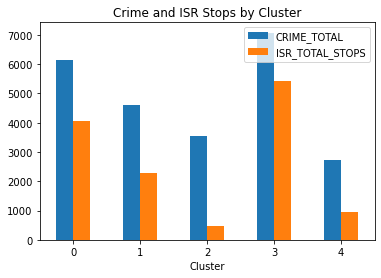

In [12]:
# Plot main features by cluster
sum_cols = ['CRIME_TOTAL', 'ISR_TOTAL_STOPS', 'UOF_TOTAL_COUNT', 'COMPLAINTS_TOTAL']
cluster_training_data.groupby(['Cluster'])['CRIME_TOTAL', 'ISR_TOTAL_STOPS'].mean().plot.bar()
plt.xticks(rotation=0)
plt.title('Crime and ISR Stops by Cluster')

<ipython-input-13-fe70a207399f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_training_data.groupby(['Cluster'])['UOF_TOTAL_COUNT', 'COMPLAINTS_TOTAL'].mean().plot.bar()


Text(0.5, 1.0, 'Use of Force and ISR Stops by Cluster')

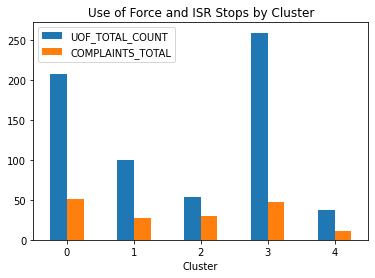

In [13]:
cluster_training_data.groupby(['Cluster'])['UOF_TOTAL_COUNT', 'COMPLAINTS_TOTAL'].mean().plot.bar()
plt.xticks(rotation=0)
plt.title('Use of Force and ISR Stops by Cluster')

### Demographic characteristics

In [14]:
demog_data = data.copy()
demog_data = demog_data.drop('YEAR',axis=1).groupby(by='BEAT').agg(np.mean)
cols = [c for c in demog_data.columns if 'CENSUS' in c]
demog_data = demog_data[cols]

In [15]:
# Merge in all data
cluster_demo_data = clustered_data.merge(demog_data.reset_index(), on='BEAT')

In [16]:
cluster_demo_data.groupby(['Cluster'])[cols].mean()

,CENSUS_TOTAL POP,CENSUS_WHITE,CENSUS_BLACK,CENSUS_HISPANIC,CENSUS_MEDIAN INCOME
Cluster,,,,,
0,6425.374238,0.044985,0.918365,0.049320,29777.082114
1,8603.296241,0.207092,0.672488,0.179916,43036.846173
2,6503.365610,0.109130,0.669530,0.035538,49635.333333
3,6259.553707,0.065896,0.819356,0.149190,31257.788235
4,11460.867458,0.556972,0.236831,0.276236,67056.866177


<ipython-input-17-436433dacfce>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_demo_data.groupby(['Cluster'])['CENSUS_BLACK', 'CENSUS_WHITE', 'CENSUS_HISPANIC'].mean().plot.bar()


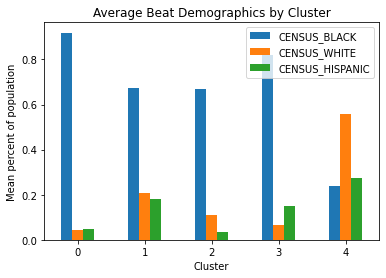

In [17]:
cluster_demo_data.groupby(['Cluster'])['CENSUS_BLACK', 'CENSUS_WHITE', 'CENSUS_HISPANIC'].mean().plot.bar()
plt.title('Average Beat Demographics by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean percent of population')
plt.xticks(rotation=0)
plt.savefig('../report/figures/baseline/demographics_chosen_cluster.png', dpi=300)

## Plot by beat

<ipython-input-22-1c4738de7d80>:2: UserWarning: Trying to register the cmap 'clusterpalette' which already exists.
  cm.register_cmap(name='clusterpalette', cmap=consistent_palette)


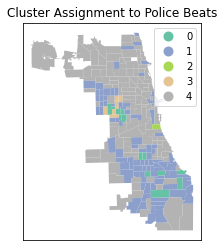

In [22]:
consistent_palette = cm.get_cmap('Set2', 5)
cm.register_cmap(name='clusterpalette', cmap=consistent_palette)
clustered_data['Cluster'] = clustered_data['Cluster'].astype(str)
beats_gdf.merge(clustered_data, on='BEAT').plot(column='Cluster', legend=True, cmap='clusterpalette')
plt.title('Cluster Assignment to Police Beats')
plt.xticks([])
plt.yticks([])
plt.savefig('../report/figures/baseline/cluster_assignment_to_beats.png', dpi=300)

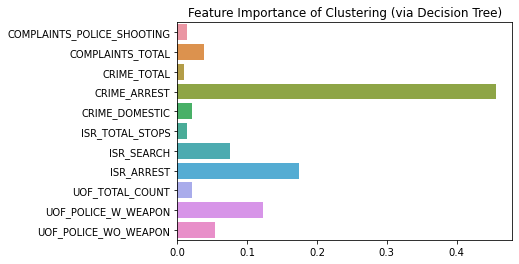

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Tree on PCA data
tree = DecisionTreeClassifier()
tree.fit(clustered_data.drop('Cluster',axis=1), clustered_data['Cluster'])
# sns.barplot(y=clustered_data.drop('Cluster',axis=1).columns, x=tree.feature_importances_)

# Tree on feature-space data
drop_cols = ['Cluster', 'PC1','PC2','PC3','PC4','PC5','PC6','BEAT']
tree.fit(cluster_training_data.drop(drop_cols,axis=1), cluster_training_data['Cluster'])
g = sns.barplot(y=cluster_training_data.drop(drop_cols,axis=1).columns, x=tree.feature_importances_)
g.set(title='Feature Importance of Clustering (via Decision Tree)')
plt.savefig("../report/figures/baseline/feature_importance_bar.png")

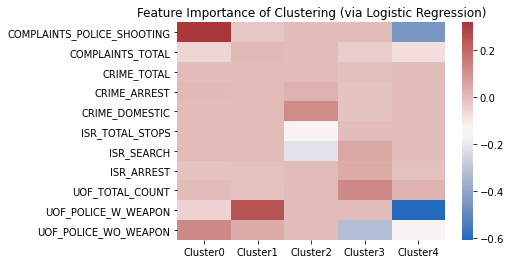

In [20]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(penalty='l1', solver='liblinear')
lm.fit(cluster_training_data.drop(drop_cols,axis=1), cluster_training_data['Cluster'])
n_classes = lm.coef_.shape[0]
n_features = lm.coef_.shape[1]
g = sns.heatmap(np.transpose(lm.coef_), xticklabels = [f"Cluster{i}" for i in range(n_classes)], yticklabels=cluster_training_data.drop(drop_cols,axis=1).columns, cmap='vlag')
g.set(title='Feature Importance of Clustering (via Logistic Regression)')
plt.savefig("../report/figures/baseline/feature_importance_map.png")